# WSI zad2 Algorytm genetyczny
Jakub Płudowski 300464
Prowadzący ćwiczenia mgr. inż. Jakub Łyskawa

### Importing needed libraries

In [203]:
import numpy as np
from numpy.random import rand
import pandas as pd
import matplotlib.pyplot as plt
import random

### Defining model

In [204]:
def calculate_gain(how_many_fuel, achieved_height):
    if achieved_height > minimal_height:
        return 200 - how_many_fuel
    else:
        return 0
    
def calculate_mass(how_many_fuel):
    return 20 +how_many_fuel

def calculate_friction_acceleration(current_velocity, mass):
#     print(f'Calculating friction for ship with mass = {mass}. Current friction = {-0.06 * current_velocity * abs(current_velocity)/mass}.')
    return (-0.06 * current_velocity * abs(current_velocity)/mass)

def calculate_acceleration(mass, current_velocity, engine_status):
    if engine_status:
        mass -= 1
#         print(f"Engine on! Actual amount of fuel: {mass-20}")
#         print(500/mass - 0.9 - calculate_friction_acceleration(current_velocity, mass))
        return (500/mass - 0.9 - calculate_friction_acceleration(current_velocity, mass)), mass
    else:
#         print("Engine off!")
#         print(-0.9 - calculate_friction_acceleration(current_velocity, mass))
        return (-0.9 + calculate_friction_acceleration(current_velocity, mass)), mass

def calculate_fuel(subject):
    return np.sum(subject)


def generate_random_subject(how_many_steps):
    A = np.zeros((1,how_many_steps))
    A = np.where(np.random.random(A.shape) < probability_of_one, 1, A)
#     print(A)
    return A



def calculate_next_position(current_position, current_velocity, current_acceleration):
    next_postition = current_acceleration/2 + current_velocity + current_position
    next_velocity = current_acceleration + current_velocity
    return next_postition, next_velocity
def perform_rocket_flight(subject, plots=False):
    how_many_fuel = calculate_fuel(subject)
    mass = calculate_mass(how_many_fuel)
#     print(f'This rocket has {how_many_fuel} fuel units and it weights {mass}t.')
    x = np.zeros((1,how_many_steps))
    v = np.zeros((1,how_many_steps))
    a = np.zeros((1,how_many_steps))
    
    for i in range(1,how_many_steps):
        a[0,i-1], mass = calculate_acceleration(mass, v[0,i-1], subject[0,i-1])
        x[0,i], v[0,i] = calculate_next_position(x[0,i-1], v[0,i-1], a[0,i-1] )
        
    achieved_height = x[0,-1]
#     print(f'Rocket has achieved height of {achieved_height}.')
    
    if plots:
        x_to_df = np.reshape(x, (how_many_steps,1))
        v_to_df = np.reshape(v, (how_many_steps,1))
        a_to_df = np.reshape(a, (how_many_steps,1))
        binary = np.reshape(subject, (how_many_steps,1))
        data = np.concatenate((x_to_df,v_to_df,a_to_df, binary), axis=1)

        df = pd.DataFrame(data, columns=['X', 'V', 'A', 'Engine Status'])

        x_axis = np.linspace(1,how_many_steps,how_many_steps)
        plt.subplot(1, 3, 1)
        plt.plot(x_axis,x_to_df)
        plt.title('Height')
        plt.subplot(1, 3, 2)
        plt.plot(x_axis,v_to_df)
        plt.title('Velocity')
        plt.subplot(1, 3, 3)
        plt.plot(x_axis,a_to_df)
        plt.title('Acceleration')

        plt.show()
    
    gain = calculate_gain(how_many_fuel, achieved_height)
    return gain
    
    

### Testing model performance
Using 3 plots, which represent state of the rocket 

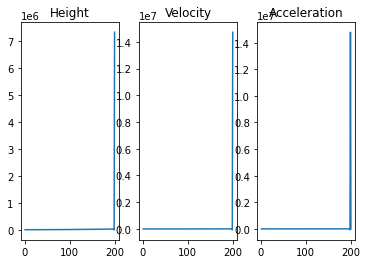

95.0

In [207]:
start_x = 0
start_v = 0
how_many_steps = 200
minimal_height = 750
probability_of_one = 0.5
subject = generate_random_subject(how_many_steps)
gain = perform_rocket_flight(subject, plots=True)
gain

### Defining genetic algorithm functions

In [194]:

def calculate_gain_for_chromosome(chromosome):
    this_population = np.reshape(chromosome, (1,chromosome.shape[0]))
    return perform_rocket_flight(this_population)

def calculate_gain_for_population(population):
    k = np.ones((2))
    gain_values = np.zeros((population.shape[0]), dtype=float)
    for i in range(population.shape[0]):
        this_population = population[i,:]
        this_population = np.reshape(this_population, (1,population.shape[1]))
        gain_values[i] = perform_rocket_flight(this_population)
    return gain_values

def crossover(x,y, prob_C):
    subject1 = x.copy()
    subject2 = y.copy()
    if rand() < prob_C:
        cross_point = random.randint(1, len(subject1)-2)
        subject1 = np.concatenate((x[:cross_point], y[cross_point:]), axis = 0)
        subject2 = np.concatenate((y[:cross_point], x[cross_point:]), axis = 0)
    return subject1, subject2

def mutate(x, prob_M):
    for i in range(x.shape[0]):
        if rand() < prob_M:
            x[i] = 1 - x[i]
            
def roulette_selection(population):
    scores = np.zeros((population.shape[0]))
    norm_scores = np.zeros((population.shape[0]))
    dystrybuanta = np.zeros((population.shape[0]))
    for i in range(population.shape[0]):
        scores[i] = calculate_gain_for_chromosome(population[i][:])
    norm_scores[:] = scores[:]/sum(scores)
    dystrybuanta[0] = norm_scores[0]
    i= 1 
    for score in (norm_scores[1:]):
        dystrybuanta[i] = dystrybuanta[i-1] + score
        i+=1
    
    randoms = np.random.rand(population.shape[0])
    should_reproduce = np.zeros((population.shape[0]))
    
    for random in randoms:
        for i in range(len(should_reproduce)):
            if random < dystrybuanta[i]:
                should_reproduce[i] +=1 
                break
        
    new_population = np.zeros(population.shape)
    iterator = 0
#     print(should_reproduce)
    for i in range(len(should_reproduce)):
        if should_reproduce[i] > 0:
            for j in range(int(should_reproduce[i])):
                new_population[iterator][:] = population[i][:]
                iterator +=1
 
    return new_population

def divide_into_pairs(population):
    indexes = list(range(population.shape[0]))
    pairs = []
    if len(indexes) % 2 ==1:
        indexes.pop(random.randint(0,len(indexes)-1))
    while len(indexes) > 0:
        first_in_pair = indexes.pop(random.randint(0,len(indexes)-1))
        second_in_pair = indexes.pop(random.randint(0,len(indexes)-1))
        pairs.append([population[first_in_pair][:], population[second_in_pair][:]])
    return pairs

def perform_crossover_on_population(population, prob_C):
    pairs = divide_into_pairs(population)
    new_population = population.copy()
    i= 0
    for pair in pairs:
        new_population[i][:], new_population[i+1][:] = crossover(pair[0], pair[1], prob_C)
        i+=2
    
    return new_population
        
        
    

### Testing funcionalities
Algorytm będzie testowany na konkretnym seedzie, aby 'losowe' rzeczy były powtarzalne i dało się je testować.

In [232]:
np.random.seed(300464)
prob_C = 0.8
prob_M = 0.1

start_population_number = 100
max_iterations = 1e5
probability_of_one = 0.05


start_population = np.zeros((100,200))
start_population = np.where(np.random.random(start_population.shape) < probability_of_one, 1, start_population)
g1 = calculate_gain_for_population(start_population)
# print(g1)
# print(start_population)
new_p = roulette_selection(start_population)
g2 = calculate_gain_for_population(new_p)
# print(g2)
# print(new_p)
# print(start_population)
# print('\n\n\n')
# children = perform_crossover_on_population(start_population, 1)
# print(children)

## Genetic algorithm

In [225]:
def genetic_algorithm(n_iter, n_pop, prob_C, prob_M, prob_1):
    population = np.zeros((n_pop,how_many_steps))
    population = np.where(np.random.random(population.shape) < prob_1, 1, population)
    best_chromosome, best_score = 0, calculate_gain_for_chromosome(population[0][:])
    results = []
    iterator = 0
    while iterator < n_iter:
#         print('\nPopulation:\n', population[0][:])
        scores = calculate_gain_for_population(population)
        for i in range(n_pop):
            if scores[i] > best_score:
                best_chromosome, best_score = population[i][:], scores[i]

        
        children = roulette_selection(population)
#         print('\nPopulation after selection:\n', children[0][:])
        mixed_children = perform_crossover_on_population(children, prob_C)
#         print('\nPopulation after crossover:\n', mixed_children[0][:])
        for i in range(mixed_children.shape[0]):
            mutate(mixed_children[i][:], prob_M)
#         print('\nPopulation after mutation:\n', mixed_children[0][:])
        results.append(best_score)
        population = mixed_children
        iterator +=1
      
    print('Best chromosome is:\n',best_chromosome)
    print('Best score is:\n',best_score)
    
    x = range(0,n_iter)
    plt.plot(x, results)
    plt.xlabel('Iteracje')
    plt.ylabel('Funkcja zysku')
    plt.title('Dzialanie algorytmu genetycznego')
    plt.show()
    

### Algorithm test

<ipython-input-204-54fa7eb553e3>:12: RuntimeWarning: overflow encountered in double_scalars
  return (-0.06 * current_velocity * abs(current_velocity)/mass)
<ipython-input-194-34cd62924a99>:34: RuntimeWarning: invalid value encountered in true_divide
  norm_scores[:] = scores[:]/sum(scores)
<ipython-input-204-54fa7eb553e3>:38: RuntimeWarning: invalid value encountered in double_scalars
  next_postition = current_acceleration/2 + current_velocity + current_position
<ipython-input-204-54fa7eb553e3>:39: RuntimeWarning: invalid value encountered in double_scalars
  next_velocity = current_acceleration + current_velocity


Best chromosome is:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0.
 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 0.]
Best score is:
 158.0


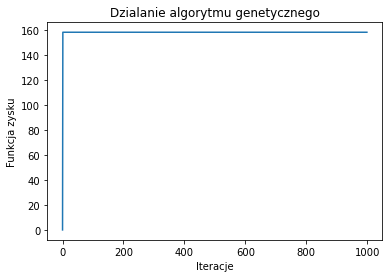

In [235]:
genetic_algorithm(1000, 200, 0.8, 0.3, 1)

### Testing hyperparameters
Algorytm testowano na losowo wybranych populacjach początkowych z równym prawdopodobieństwem 0 i 1.
Algorytm przetestowano dla różnych wartości prawdopodobieństwa krzyżowania. Optymalne prawdopodobieństwo to 0.8. Powinno ono być wysokie, ale mniejsze od 1, aby krzyżowanie było 'losowe', a nie pewne. Poniżej przedstawiono testy działania algorytmu.

Dla prob_C = 0.4 (best score = 135)
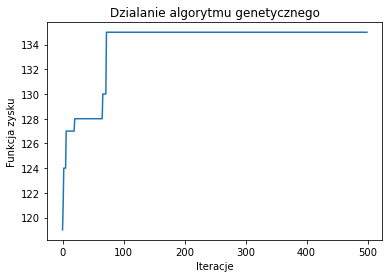
Dla prob_C = 0.5 (best score = 132)
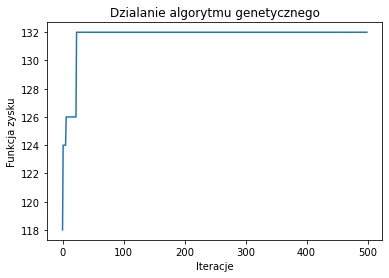
Dla prob_C = 0.6 (best score = 132)
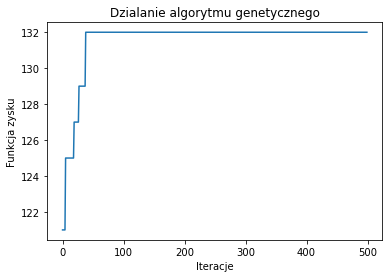
Dla prob_C = 0.7 (best score = 134)
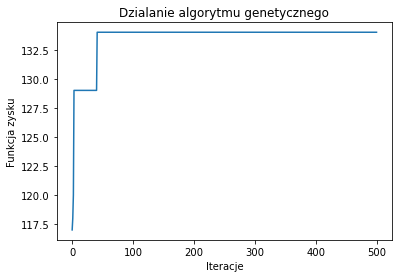
Dla prob_C = 0.8 (best score = 134)
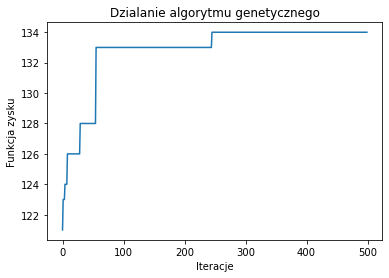
Dla prob_C = 0.8 (best score = 131)
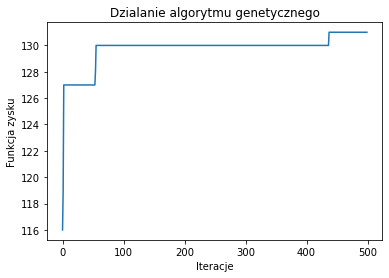

<ipython-input-204-54fa7eb553e3>:12: RuntimeWarning: overflow encountered in double_scalars
  return (-0.06 * current_velocity * abs(current_velocity)/mass)
<ipython-input-204-54fa7eb553e3>:38: RuntimeWarning: invalid value encountered in double_scalars
  next_postition = current_acceleration/2 + current_velocity + current_position
<ipython-input-204-54fa7eb553e3>:39: RuntimeWarning: invalid value encountered in double_scalars
  next_velocity = current_acceleration + current_velocity


Best chromosome is:
 [1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 1.]
Best score is:
 135.0


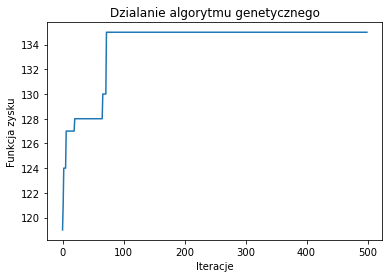

Best chromosome is:
 [0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.
 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 1.]
Best score is:
 132.0


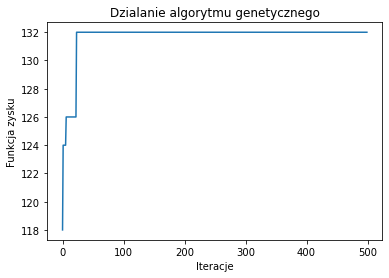

Best chromosome is:
 [1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.
 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1.
 0. 0. 0. 0. 1. 0. 1. 0.]
Best score is:
 132.0


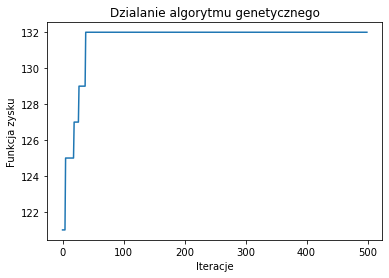

Best chromosome is:
 [0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0.
 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 1. 0.]
Best score is:
 134.0


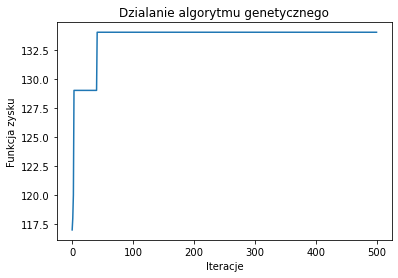

Best chromosome is:
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.
 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 1. 0. 1.]
Best score is:
 134.0


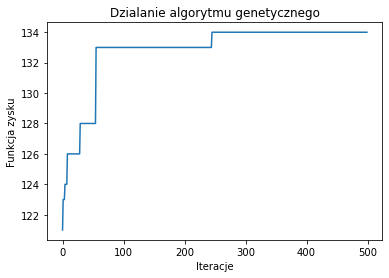

Best chromosome is:
 [1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.
 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0.
 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1.
 0. 1. 1. 0. 0. 0. 0. 0.]
Best score is:
 131.0


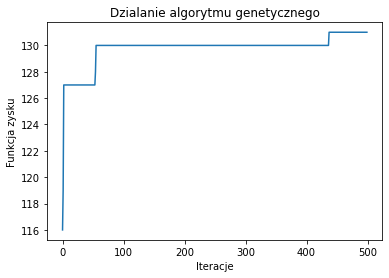

In [230]:
for pc in [0.4,0.5,0.6,0.7,0.8,0.9]:
    genetic_algorithm(500, 200, pc,0.1, 0.5)
    
    

Algorytm przetestowano dla różnych wartości prawdopodobieństwa mutacji. Optymalne prawdopodobieństwo to 0.1. Powinno ono być niskie, aby nie wprowadziało chaosu ale nie za małe, aby mogło wybić algorytm z minimum lokalnego. Poniżej przedstawiono testy działania algorytmu.

Dla prob_M = 0.05 (best score = 135)
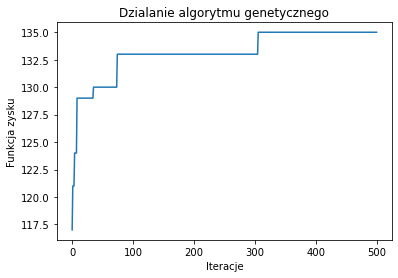
Dla prob_M = 0.1 (best score = 134)
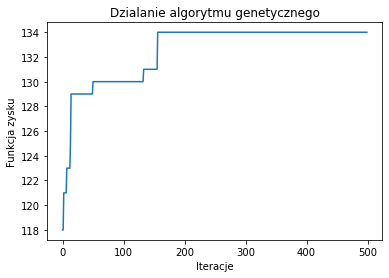
Dla prob_M = 0.15 (best score = 135)
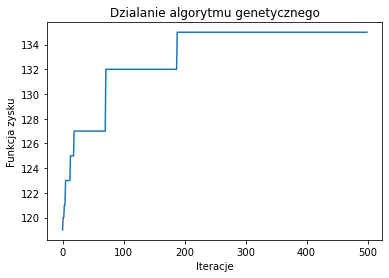
Dla prob_M = 0.2 (best score = 133)
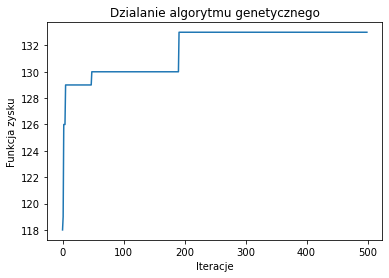
Dla prob_M = 0.25 (best score = 134)
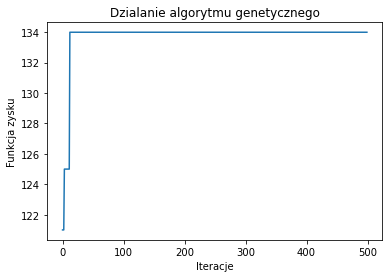
Dla prob_M = 0.3 (best score = 133)
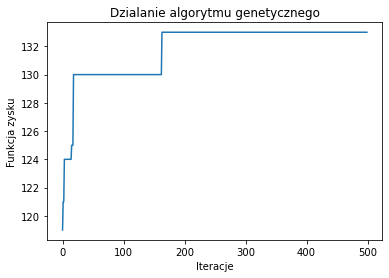

<ipython-input-204-54fa7eb553e3>:12: RuntimeWarning: overflow encountered in double_scalars
  return (-0.06 * current_velocity * abs(current_velocity)/mass)
<ipython-input-204-54fa7eb553e3>:38: RuntimeWarning: invalid value encountered in double_scalars
  next_postition = current_acceleration/2 + current_velocity + current_position
<ipython-input-204-54fa7eb553e3>:39: RuntimeWarning: invalid value encountered in double_scalars
  next_velocity = current_acceleration + current_velocity


Best chromosome is:
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1.
 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 1. 1. 0.]
Best score is:
 135.0


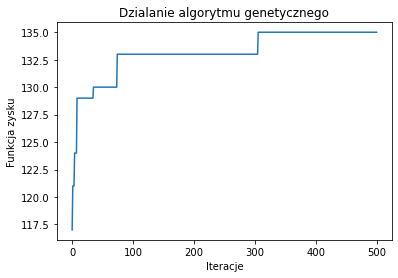

Best chromosome is:
 [0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1.
 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1.
 0. 1. 1. 1. 0. 0. 1. 0.]
Best score is:
 134.0


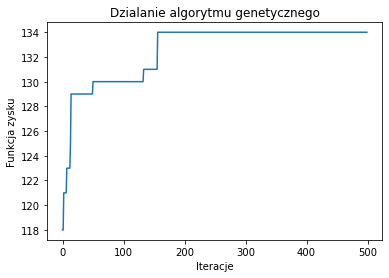

Best chromosome is:
 [1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 1. 0. 1.]
Best score is:
 135.0


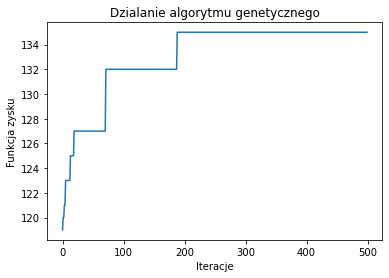

Best chromosome is:
 [0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0.
 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1.]
Best score is:
 133.0


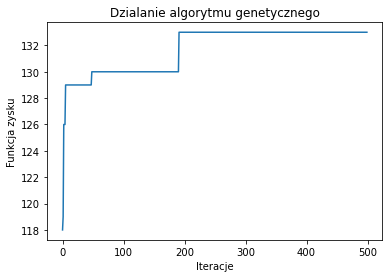

Best chromosome is:
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1.
 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.
 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0.
 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0.]
Best score is:
 134.0


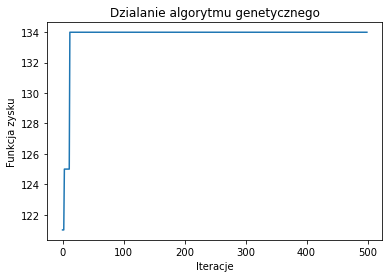

Best chromosome is:
 [0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1.
 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0.
 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0.]
Best score is:
 133.0


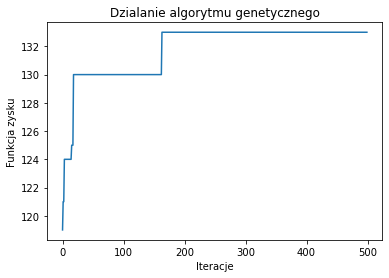

In [233]:
for pm in [0.05,0.1,0.15,0.2,0.25,0.3]:
    genetic_algorithm(500, 200, 0.8,pm, 0.5)

## Wnioski
Algorytm genetyczny jest bardzo wolny i bardzo łatwo jest mu utknąć w optimum lokalnym. Populacja na, której algorytm działa powinna być stosunkowo duża. Dzieki temu można zapewnić dużą różnorodność w populacji. Niestety ta duża liczba również wydłuża działanie algorytmu w znaczący sposób. Prawdopodobieństwo krzyżowanai powinno być wysokie, aby osobniki mogły wymieniać się dobrymi genami. Po kilku selekcjach ruletkowych w populacji powinny zostać tylko najlepsze osobniki, więc krzyżowanie między nimi jest bardzo wskazane. Mutacja, jako że wpływa na każdy gen powinna być mało prawdopodobna, aby nie wprowadzała chaosu, jednak powinna być możliwa, aby mozna było wyjść z optimum lokalnego. 
Poniżej przedstawiono przykładowe działanie takiego algorytmu. Wykresy te nie oddają prawdziwych własności tego algorytmu, ponieważ były on wykorzystywane za krótko. Z uwagi na słabą moc obliczeniową komputera 1000 iteracji dla populacji o wielkości 500 osobników trwało kilka minut.
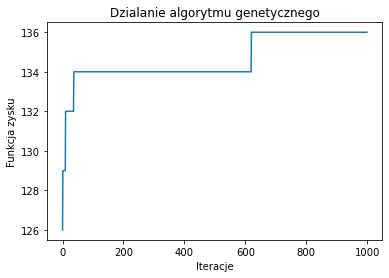
Inny przykład
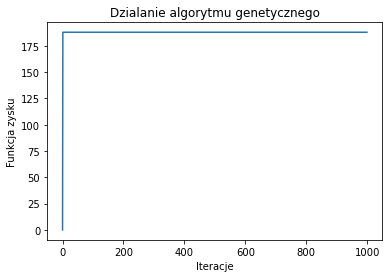

Najlepszy wynik jaki algorytm osiągnał to 188
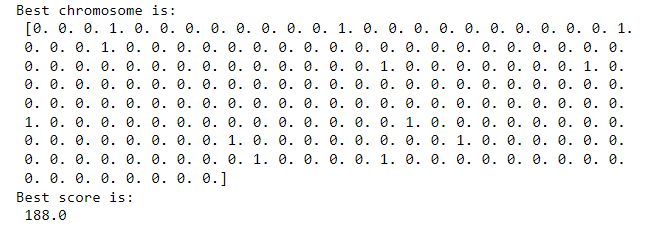